In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lesson 33: Regression Inference

Let's start by loading up the functions that have been used in the last few lessons

In [2]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

This function will recreate the process of using a true line to generate a set of data assuming that points *should* fall on the line, but due to random errors get "pushed" away by a random amount for each point. The size of the "push" is comes from a random distribution with mean of 0 and standard deviation of 2.

In [13]:
def draw_and_compare(true_slope, true_int, sample_size):
    # Chooses x-values from a distribution of mean 5 and SD of 2.5
    # you can edit these values if you want!
    x = np.random.normal(5, 2.5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    
    # Chooses errors from a distribution with mean 0 and SD of 2
    # You can edit these values if you want!
    errors = np.random.normal(0, 2, sample_size)
    
    # Computes the y-value on the "true" line, then adds the error amount
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    # This code creates the four graphs
    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='magenta')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

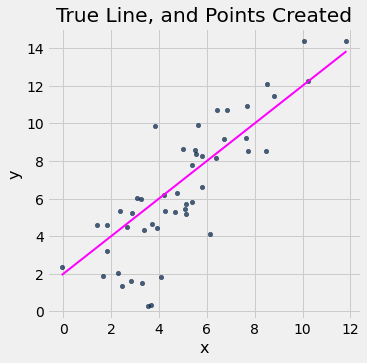

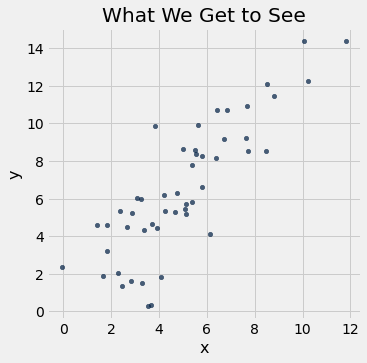

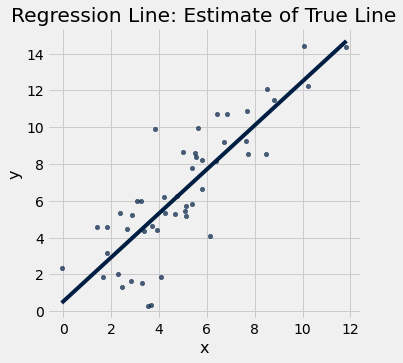

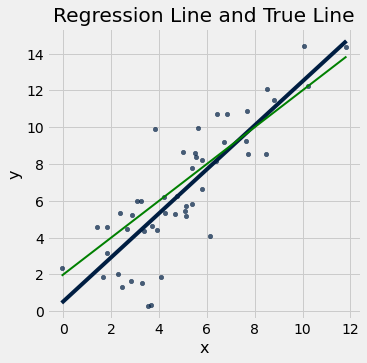

In [15]:
draw_and_compare(1, 2, 50)

## Making Predictions

We'll load the `births` data set, but only keep those that occur between 225 days and 325 days, since those are the definitions of pre-term and post-term respectively as defined by the CDC. This ensures that we're analyzing only birth weights for babies that are considered "full term". Babies born premature or after full term may be considered outliers because they occur much less frequently and may not fit the pattern for full term babies.

In [16]:
births = Table.read_table('data/baby.csv').where('Gestational Days', are.between(225, 325))
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
144,282,32,64,124,True


This data set is considered a single sample, albeit a somewhat large one. The population would be considered all full term babies ever born in the US, which is a data set far too large for us to ever think of collecting and analyzing. This single sample will however allow for some predictions to be made.

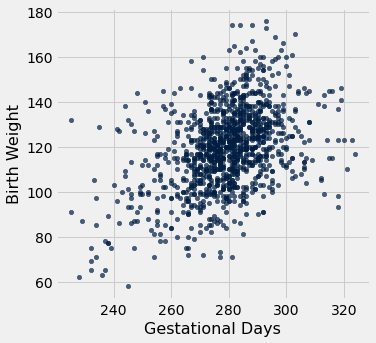

In [17]:
births.scatter('Gestational Days', 'Birth Weight')

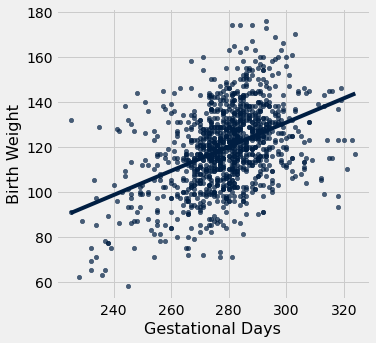

In [18]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)

In [19]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.4229511845242399

In [20]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [21]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.8095167424877

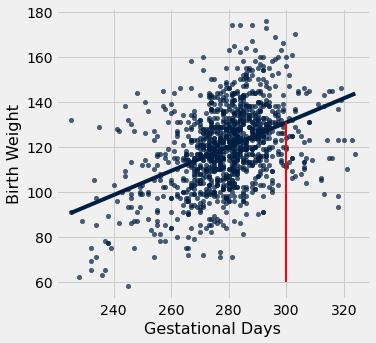

In [22]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([300, 300], [60, prediction_at_300], color='red', lw=2);

This is the best prediction we could make using this single sample. However, as we've learned previously we can bootstrap a single sample to generate new samples that will contain some similar tendencies of the population. It's essential that the bootstrap samples are created *with replacement*, otherwise you'll obtain the exact same sample each time.

The code below will create 5 bootstrap samples to illustrate that this process does in fact create a new sample to work with each time.

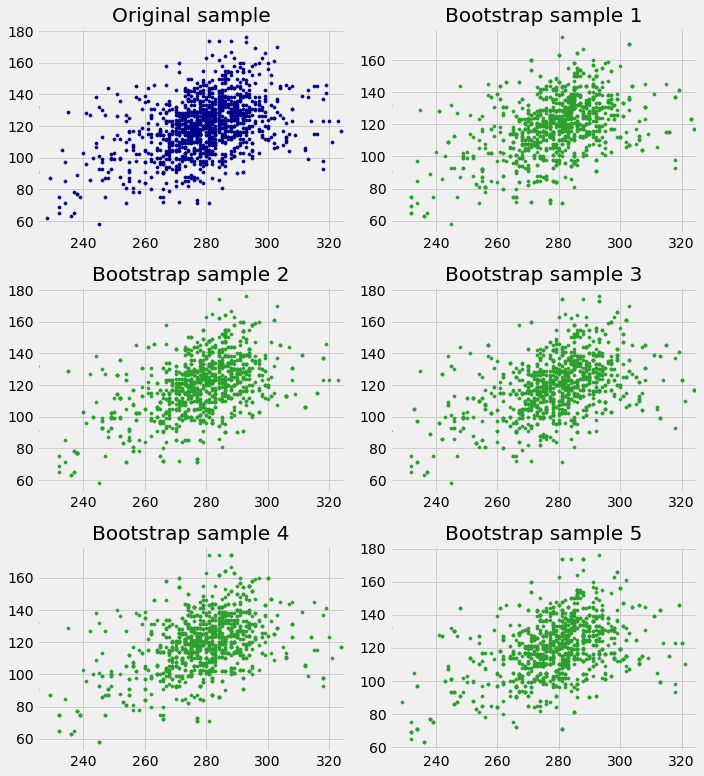

In [23]:
# You don't need to understand the plotting code in this cell,
# but you should understand the figure that comes out.

plots.figure(figsize=(10, 11))
plots.subplot(3, 2, 1)
plots.scatter(births[1], births[0], s=10, color='darkblue')
plots.xlim([225, 325])
plots.title('Original sample')

for i in np.arange(1, 6, 1):
    plots.subplot(3,2,i+1)
    resampled = births.sample()
    plots.scatter(resampled.column('Gestational Days'), resampled.column('Birth Weight'), s=10, color='tab:green')
    plots.xlim([225, 325])
    plots.title('Bootstrap sample '+str(i))
plots.tight_layout()

Predicted y from bootstramp sample was 131.57825999361586
Predicted y from bootstramp sample was 129.79766223341448
Predicted y from bootstramp sample was 130.18371301450378
Predicted y from bootstramp sample was 131.07553603495953


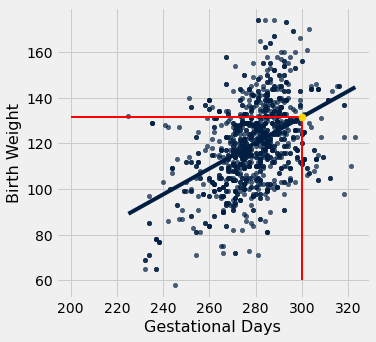

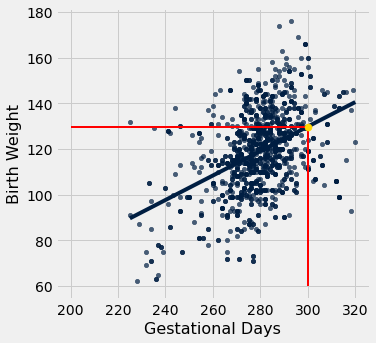

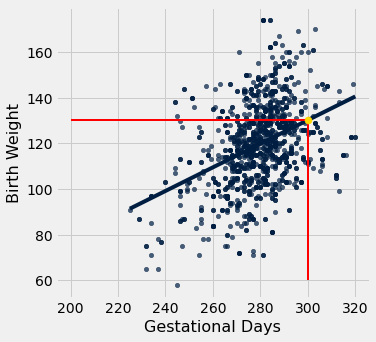

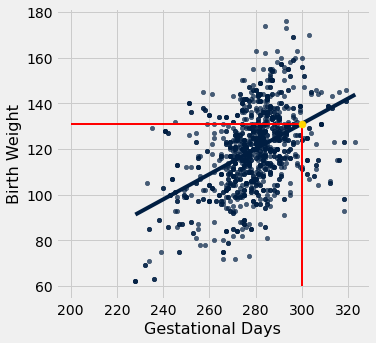

In [24]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstramp sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([300, 300], [60, predicted_y], color='red', lw=2);
    plots.plot([200, 300], [predicted_y, predicted_y], color='red', lw=2);

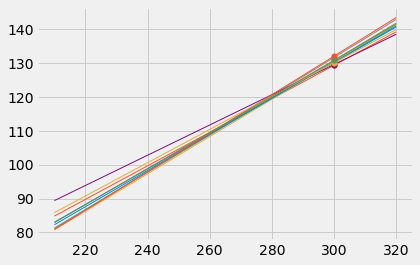

In [25]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)

## Confidence Interval for Prediction

In [26]:
def bootstrap_prediction(t, x_col, y_col, x_value, repetitions=1000):
    """ 
    Makes a 95% confidence interval for the prediction at new_x, using
    linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x_col, y_col, x_value)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(x_value))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line:')
    print(left, right, '(width =', right - left, ')')

Approximate 95%-confidence interval for height of true line:
119.1739337598937 121.04401907082108 (width = 1.8700853109273794 )


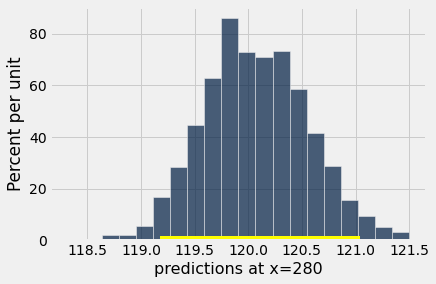

In [30]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

As you move away from the average x-value, the width of your prediction interval will grow, meaning your predictions will become less precise.

In [32]:
np.mean(births.column('Gestational Days'))

279.1101549053356

In [33]:
np.mean(births.column('Birth Weight'))

119.57401032702238

Approximate 95%-confidence interval for height of true line:
119.11060147146206 121.00470045810351 (width = 1.8940989866414526 )


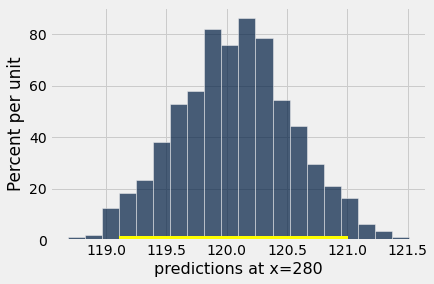

In [34]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)

Approximate 95%-confidence interval for height of true line:
101.41358283313859 106.58324284432535 (width = 5.169660011186764 )


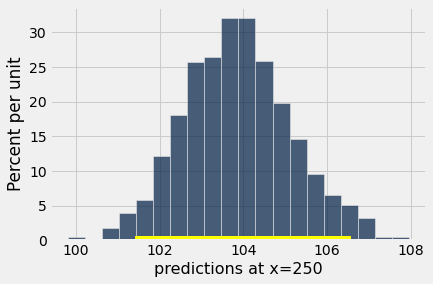

In [35]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 250)

Approximate 95%-confidence interval for height of true line:
83.16085312061502 92.22873857374886 (width = 9.06788545313384 )


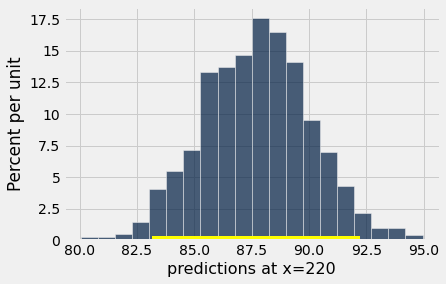

In [36]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 220)